In [1]:
%load_ext autoreload
%autoreload 2
import argparse
import logging
import os

import numpy as np
import torch
import torch.optim as optim
from torch.autograd import Variable
from tqdm import tqdm

import utils
import model.net_pretrained as net
import model.data_loader_normalize4densenet as data_loader
from evaluate import evaluate
from final_metrics import final_metrics
import matplotlib.pyplot as plt






In [2]:
#data_dir = '/home/data/FETAL/30_slice_data'
data_dir = '/home/data/FETAL'
#data_dir= '/home/sbakr/data'
model_dir = 'experiments/lre_3_pretrainedT_augmentF_batchsize8_normalize4densenetT'
restore_file = None 
metrics_filename="metric_data.txt"

In [3]:
def train(model, optimizer, loss_fn, dataloader, metrics, params, epoch_num):
    """Train the model on `num_steps` batches

    Args:
        model: (torch.nn.Module) the neural network
        optimizer: (torch.optim) optimizer for parameters of model
        loss_fn: a function that takes batch_output and batch_labels and computes the loss for the batch
        dataloader: (DataLoader) a torch.utils.data.DataLoader object that fetches training data
        metrics: (dict) a dictionary of functions that compute a metric using the output and labels of each batch
        params: (Params) hyperparameters
        num_steps: (int) number of batches to train on, each of size params.batch_size
    """

    # set model to training mode
    model.train()

    # summary for current training loop and a running average object for loss
    summ = []
    all_outputs=[]
    all_labels=[]
    loss_avg = utils.RunningAverage()

    # Use tqdm for progress bar
    with tqdm(total=len(dataloader)) as t:
        for i, (train_batch, labels_batch) in enumerate(dataloader):
            # move to GPU if available
            if params.cuda:
                train_batch, labels_batch = train_batch.cuda(async=True), labels_batch.cuda(async=True)
            # convert to torch Variables
            train_batch, labels_batch = Variable(train_batch), Variable(labels_batch)

            # compute model output and loss
            output_batch = model(train_batch)
            loss = loss_fn(output_batch, labels_batch)

            # clear previous gradients, compute gradients of all variables wrt loss
            optimizer.zero_grad()
            loss.backward()

            # performs updates using calculated gradients
            optimizer.step()

            
            all_labels.append(labels_batch)
            all_outputs.append(output_batch)

            
            # Evaluate summaries only once in a while
            
            if i % params.save_summary_steps == 0:
                #import pdb; pdb.set_trace()
                # extract data from torch Variable, move to cpu, convert to numpy arrays
                output_batch = output_batch.data.cpu().numpy()
                labels_batch = labels_batch.data.cpu().numpy()

                # compute all metrics on this batch
                summary_batch = {metric:metrics[metric](output_batch, labels_batch)
                                 for metric in metrics}
                summary_batch['loss'] = loss.data[0]
                summ.append(summary_batch)

            # update the average loss
            loss_avg.update(loss.data[0])

            t.set_postfix(loss='{:05.3f}'.format(loss_avg()))
            t.update()
            
    #import pdb; pdb.set_trace()
    all_labels=torch.cat(all_labels, 0)
    all_outputs=torch.cat(all_outputs, 0)
    
    
    all_predictions = np.argmax((all_outputs.data).cpu().numpy(), axis=1)
    all_labels=all_labels.data.cpu().numpy()
    
    precision, recall, F1, accuracy= final_metrics(all_predictions, all_labels)
    metrics_path = os.path.join(model_dir, metrics_filename)
    with open(metrics_path, "a") as f:
        f.write("train " + str(epoch_num) + " precision " + str(precision) + "\n")
        f.write("train " + str(epoch_num) + " recall " + str(recall) + "\n")
        f.write("train " + str(epoch_num) + " F1 " + str(F1) + "\n")
        f.write("train " + str(epoch_num) + " accuracy " + str(accuracy) + "\n")
        f.write("train " + str(epoch_num) + " loss " + str(loss_avg()) + "\n")
    
    print("precision: %.3f ; recall: %.3f ; F1: %.3f ; accuracy: %.3f" % (precision,recall,F1,accuracy))
    
    
    # compute mean of all metrics in summary
    metrics_mean = {metric:np.mean([x[metric] for x in summ]) for metric in summ[0]}
    metrics_string = " ; ".join("{}: {:05.3f}".format(k, v) for k, v in metrics_mean.items())
    logging.info("- Train metrics: " + metrics_string)



In [4]:
def plot_metrics():

    train = {"accuracy":{}, "precision":{}, "recall":{}, "F1":{}, "loss":{}}
    eval = {"accuracy":{}, "precision":{}, "recall":{}, "F1":{}, "loss":{}}

    metrics_path = os.path.join(model_dir, metrics_filename)
    with open(metrics_path) as f:
        for lines in f:
            words = lines.split()
            if words[0] == "eval":
                eval[words[2]][words[1]] = words[3]
            elif words[0] == "train":
                train[words[2]][words[1]] = words[3]
            else:
                print("error, a line started with neither train nor eval")

    i = 1
    for keys in eval:
        x = []
        y = []
        x2 = []
        y2 = []
        plt.figure(i)
        plt.ylabel(keys)
        plt.xlabel("Epochs")
        for epochs in eval[keys]:
            x.append(int(epochs))
            y.append(float(train[keys][epochs]))
            x2.append(int(epochs))
            y2.append(float(eval[keys][epochs]))
        plt.plot(x, y)
        plt.plot(x2, y2)
        i += 1
    plt.show()


In [5]:
def train_and_evaluate(model, train_dataloader, val_dataloader, optimizer, loss_fn, metrics, params, model_dir,
                       restore_file=None):
    """Train the model and evaluate every epoch.

    Args:
        model: (torch.nn.Module) the neural network
        train_dataloader: (DataLoader) a torch.utils.data.DataLoader object that fetches training data
        val_dataloader: (DataLoader) a torch.utils.data.DataLoader object that fetches validation data
        optimizer: (torch.optim) optimizer for parameters of model
        loss_fn: a function that takes batch_output and batch_labels and computes the loss for the batch
        metrics: (dict) a dictionary of functions that compute a metric using the output and labels of each batch
        params: (Params) hyperparameters
        model_dir: (string) directory containing config, weights and log
        restore_file: (string) optional- name of file to restore from (without its extension .pth.tar)
    """
    # reload weights from restore_file if specified
    if restore_file is not None:
        restore_path = os.path.join(model_dir, restore_file + '.pth.tar')
        logging.info("Restoring parameters from {}".format(restore_path))
        utils.load_checkpoint(restore_path, model, optimizer)

    best_val_acc = 0.0

    for epoch in range(params.num_epochs):
        # Run one epoch
        logging.info("Epoch {}/{}".format(epoch + 1, params.num_epochs))

        # compute number of batches in one epoch (one full pass over the training set)
        train(model, optimizer, loss_fn, train_dataloader, metrics, params, epoch)

        # Evaluate for one epoch on validation set
        val_metrics,precision, recall,F1,accuracy,loss = evaluate(model, loss_fn, val_dataloader, metrics, params)
        metrics_path = os.path.join(model_dir, metrics_filename)
        with open(metrics_path, "a") as f:
        
            f.write("eval " + str(epoch) + " precision " + str(precision) + "\n")
            f.write("eval " + str(epoch) + " recall " + str(recall) + "\n")
            f.write("eval " + str(epoch) + " F1 " + str(F1) + "\n")
            f.write("eval " + str(epoch) + " accuracy " + str(accuracy) + "\n")
            f.write("eval " + str(epoch) + " loss " + str(loss) + "\n")
    
        val_acc = val_metrics['accuracy']
        is_best = val_acc>=best_val_acc
        

        print("precision: %.3f ; recall: %.3f ; F1: %.3f ; accuracy: %.3f" % (precision,recall,F1,accuracy))
        plot_metrics()
        # Save weights
        utils.save_checkpoint({'epoch': epoch + 1,
                               'state_dict': model.state_dict(),
                               'optim_dict' : optimizer.state_dict()},
                               is_best=is_best,
                               checkpoint=model_dir)

        # If best_eval, best_save_path
        if is_best:
            logging.info("- Found new best accuracy")
            best_val_acc = val_acc

            # Save best val metrics in a json file in the model directory
            best_json_path = os.path.join(model_dir, "metrics_val_best_weights.json")
            utils.save_dict_to_json(val_metrics, best_json_path)

        # Save latest val metrics in a json file in the model directory
        last_json_path = os.path.join(model_dir, "metrics_val_last_weights.json")
        utils.save_dict_to_json(val_metrics, last_json_path)



Loading the datasets...
- done.
Starting training for 1000 epoch(s)
Epoch 1/1000
100%|██████████| 352/352 [08:58<00:00,  1.39s/it, loss=0.388]
- Train metrics: accuracy: 0.656 ; Confusion_Matrix: 0.656 ; loss: 0.511


precision: 0.091 ; recall: 0.003 ; F1: 0.005 ; accuracy: 0.738


- Eval metrics : accuracy: 0.269 ; Confusion_Matrix: 0.269 ; loss: 6327.424


precision: 0.255 ; recall: 0.987 ; F1: 0.405 ; accuracy: 0.265


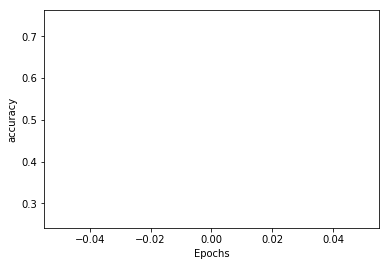

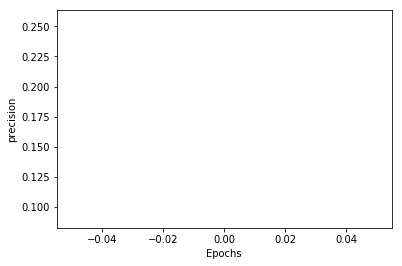

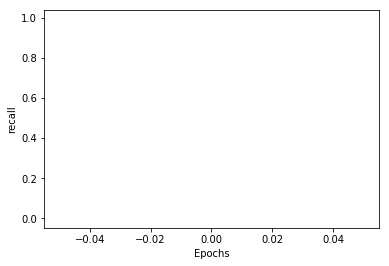

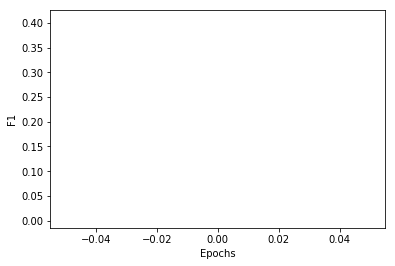

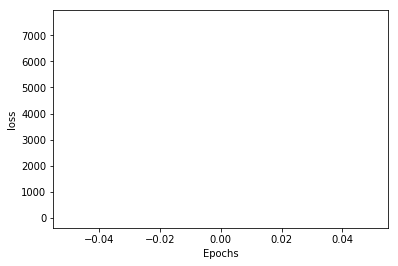

Checkpoint Directory exists! 


- Found new best accuracy
Epoch 2/1000
 39%|███▉      | 138/352 [03:10<04:32,  1.27s/it, loss=0.384]

In [ ]:
os.environ["CUDA_VISIBLE_DEVICES"] = "3"
json_path = os.path.join(model_dir, 'params.json')
assert os.path.isfile(json_path), "No json configuration file found at {}".format(json_path)
params = utils.Params(json_path)

# use GPU if available
params.cuda = torch.cuda.is_available()

# Set the random seed for reproducible experiments
torch.manual_seed(230)
if params.cuda: torch.cuda.manual_seed(230)

# Set the logger
utils.set_logger(os.path.join(model_dir, 'train.log'))

# Create the input data pipeline
logging.info("Loading the datasets...")

# fetch dataloaders
dataloaders = data_loader.fetch_dataloader(['train', 'val'], data_dir, params)
train_dl = dataloaders['train']
val_dl = dataloaders['val']

logging.info("- done.")

# Define the model and optimizer
model = net.Net(params).cuda() if params.cuda else net.Net(params)
optimizer = optim.Adam(model.parameters(), lr=params.learning_rate)

# fetch loss function and metrics
loss_fn = net.loss_fn
metrics = net.metrics

# Train the model
logging.info("Starting training for {} epoch(s)".format(params.num_epochs))
train_and_evaluate(model, train_dl, val_dl, optimizer, loss_fn, metrics, params, model_dir,
                       restore_file)
